# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

In [1]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import plotly.express as px
import pylab
import time
warnings.filterwarnings('ignore')

In [2]:
train=pd.read_csv('/datasets/gold_recovery_train.csv',parse_dates = ['date']) #обучающая выборка
test=pd.read_csv('/datasets/gold_recovery_test.csv',parse_dates = ['date']) # тестовая выборка
full=pd.read_csv('/datasets/gold_recovery_full.csv',parse_dates = ['date']) # исходные данные

In [3]:
set(train.columns) - set(test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В датасете test отсутствуют признаки output потому что это целевые признаки.
Так же в test нет признаков calculation для этапа roughe, вероятно они еще не посчитаны

### Расчет эффективности обогащения и проверка MAE

In [4]:
#Функция расчета ээфективности обогащения

def recovery(C, F, T):
    
    recovery = ((C * (F - T)) / (F * (C - T))) * 100
    return recovery

In [5]:
#Эффективность обогащения из сырых значений (rougher)

train_not_nan = train.dropna().reset_index()
rougher_output_recovery=train_not_nan['rougher.output.recovery']
rougher_output_tail_au=train_not_nan['rougher.output.tail_au']
rougher_input_feed_au=train_not_nan['rougher.input.feed_au']
rougher_output_concentrate_au=train_not_nan['rougher.output.concentrate_au']

recovery = recovery(rougher_output_concentrate_au, rougher_input_feed_au, rougher_output_tail_au)
recovery

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
11012    89.574376
11013    87.724007
11014    88.890579
11015    89.858126
11016    89.514960
Length: 11017, dtype: float64

In [6]:
#MAE между моими расчетами и значениями признака

mean_absolute_error(recovery,rougher_output_recovery)

9.555596961987514e-15

Исходя из метрики MAE, можно сказать, что значения +/- верные

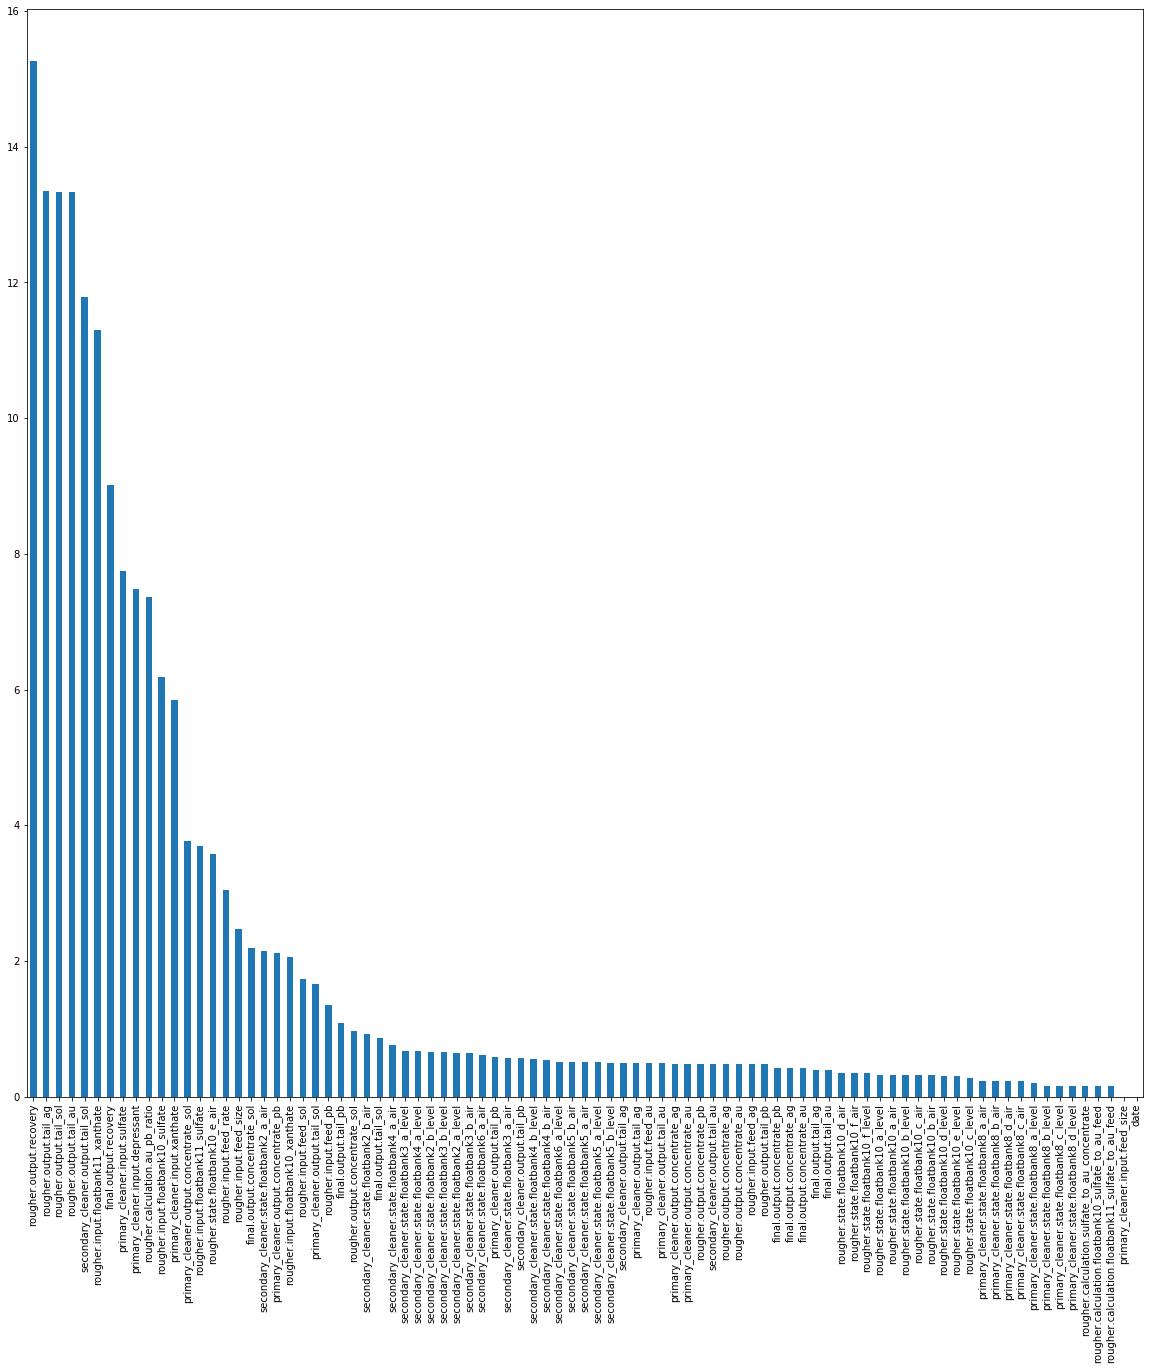

In [7]:
#Посмотрим процент пропусков

nan_train = train.isna().sum() / train.shape[0] * 100
nan_train.sort_values(ascending=False).plot.bar(figsize=(20, 20))

In [8]:
nan_train.sort_values(ascending=False)

rougher.output.recovery                               15.260973
rougher.output.tail_ag                                13.345196
rougher.output.tail_sol                               13.339265
rougher.output.tail_au                                13.339265
secondary_cleaner.output.tail_sol                     11.779359
                                                        ...    
rougher.calculation.sulfate_to_au_concentrate          0.160142
rougher.calculation.floatbank10_sulfate_to_au_feed     0.160142
rougher.calculation.floatbank11_sulfate_to_au_feed     0.160142
primary_cleaner.input.feed_size                        0.000000
date                                                   0.000000
Length: 87, dtype: float64

в train есть некоторое количество пропусков. Поскольку MAE у нас не большое и данные индексируются датой и врменем, то можно попробовать заполнить пропуски соседними значениями

### Заполнение пропусков, предобработка

In [9]:
full=full.fillna(method='ffill')
train=train.fillna(method='ffill')
test=test.fillna(method='ffill')

In [10]:
print('Количество пропусков в full', full.isna().sum())
print()
print()
print('Количество пропусков в train', train.isna().sum())

Количество пропусков в full date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64


Количество пропусков в train date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
seco

In [11]:
print('Количество дубликатов full:', full.duplicated().sum())
print()
print('Количество дубликатов train:', train.duplicated().sum())

Количество дубликатов full: 0

Количество дубликатов train: 0


## Анализ данных

In [12]:
train.columns

Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_clean

1. Этап - Флотация:

    1.1 rougher.output.concentrate_ag    
    1.2 rougher.output.concentrate_pb    
    1.3 rougher.output.concentrate_au
    
    
2. Этап - Первичная очистка:

    2.1 primary_cleaner.output.concentrate_ag    
    2.2 primary_cleaner.output.concentrate_pb    
    2.3 primary_cleaner.output.concentrate_au
    
    
3. Этап - Финальный концентрат:
    
    3.1 final.output.concentrate_ag    
    3.2 final.output.concentrate_pb    
    3.3 final.output.concentrate_au


4. Этап - Финал хвосты:

    4.1 final.output.tail_ag    
    4.2 final.output.tail_pb    
    4.3 final.output.tail_au

### Как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки

In [13]:
rougher = train[['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb']]
primary = train[['primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb']]
final = train[['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb']]
final_tail = train[['final.output.tail_au', 'final.output.tail_ag', 'final.output.tail_pb']]

In [14]:
def analytics_steps(df, step):
    
    bins = np.linspace(df.min().min(), df.max().max(), 30)

    pyplot.hist(df.iloc[:, 0], bins, alpha=0.5, label='au')
    pyplot.hist(df.iloc[:, 1], bins, alpha=0.5, label='ag')
    pyplot.hist(df.iloc[:, 2], bins, alpha=0.5, label='pb')
    pyplot.legend(loc='upper right')
    pyplot.title(step)
    

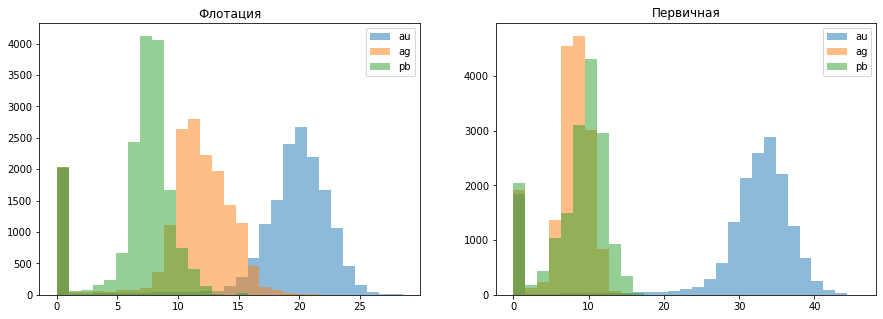

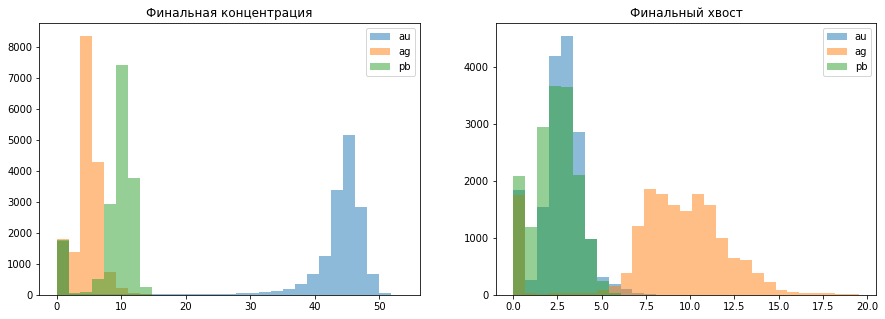

In [15]:
plt.figure(figsize=(15,5))
pylab.subplot (1, 2, 1)
analytics_steps(rougher, 'Флотация')
pylab.subplot (1, 2, 2)
analytics_steps(primary, 'Первичная')
pyplot.show()

plt.figure(figsize=(15,5))
pylab.subplot (1, 2, 1)
analytics_steps(final, 'Финальная концентрация')
pylab.subplot (1, 2, 2)
analytics_steps(final_tail, 'Финальный хвост')
pyplot.show()


Видим большое количество нулевых значений по всем металам во всех этапах. Также с каждым этапом обработки концентрация золота увеличивается. Концентрация серебра и свинца тоже увеличивалась, а на последнем этапе практически в два раза.

### Сравнение распределений размеров гранул сырья на обучающей и тестовой выборках.

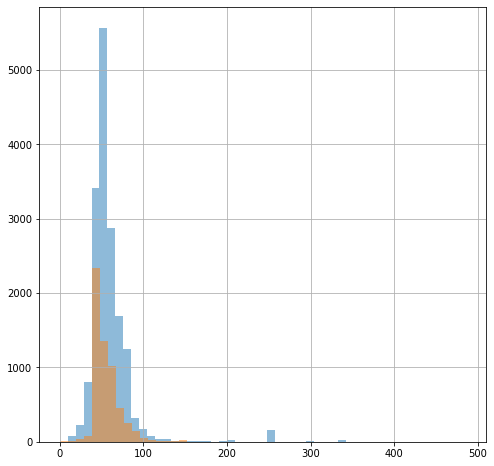

In [16]:
train['rougher.input.feed_size'].hist(bins=50, figsize=(8, 8), alpha=0.5, label='train')
test['rougher.input.feed_size'].hist(bins=50, figsize=(8, 8), alpha=0.5, label='test')

Распределения похожи друг на друга

### Cуммарная концентрация всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

In [17]:
# Сумма концентраций металлов после флотации
full['sum_concentrate_rougher']=full['rougher.output.concentrate_ag']+full['rougher.output.concentrate_pb']+full['rougher.output.concentrate_sol']+full['rougher.output.concentrate_au']

# Сумма концентраций металлов после первичной очистки
full['sum_primary_cleaner_output_concentrate']=full['primary_cleaner.output.concentrate_ag']+full['primary_cleaner.output.concentrate_pb']+full['primary_cleaner.output.concentrate_sol']+full['primary_cleaner.output.concentrate_au']

# Сумма концентраций металлов после финальной очистки
full['sum_final_output_concentrate']=full['final.output.concentrate_ag']+full['final.output.concentrate_pb']+full['final.output.concentrate_sol']+full['final.output.concentrate_au']

concentrate_sum=full[['sum_concentrate_rougher','sum_primary_cleaner_output_concentrate','sum_final_output_concentrate']]

In [18]:
#Перепишу прошлую функцию, чтобы были верные лейблы и отображались слева

def analytics_steps(df, step):
    
    bins = np.linspace(df.min().min(), df.max().max(), 30)

    pyplot.hist(df.iloc[:, 0], bins, alpha=0.5, label=concentrate_sum.columns[0])
    pyplot.hist(df.iloc[:, 1], bins, alpha=0.5, label=concentrate_sum.columns[1])
    pyplot.hist(df.iloc[:, 2], bins, alpha=0.5, label=concentrate_sum.columns[2])
    pyplot.legend(loc='upper left')
    pyplot.title(step)

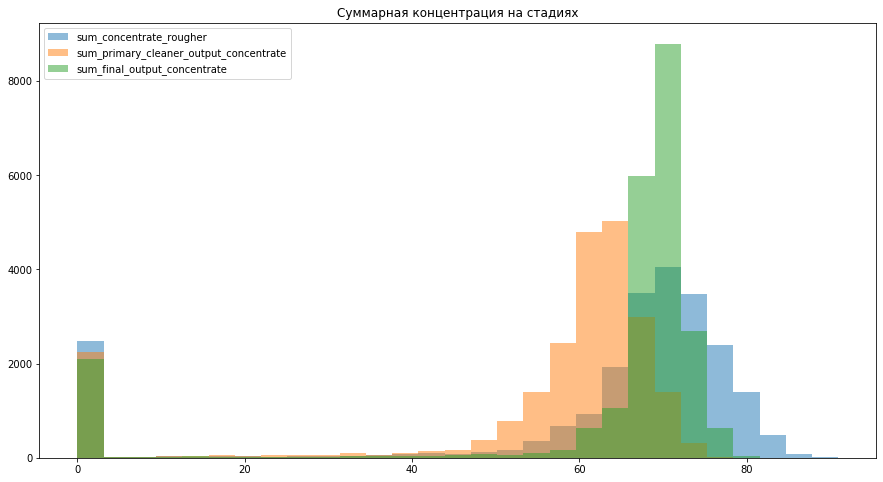

In [19]:
plt.figure(figsize=(15, 8))
analytics_steps(concentrate_sum, 'Суммарная концентрация на стадиях')

Видим, что суммарная концентрация растет с каждой следующей стадией. Также тянется хвост от 0 до 45, думаю его можно отбросить, чтобы не сказалось на обучении.

In [20]:
full=full.query('sum_final_output_concentrate > 40')
full=full.query('sum_primary_cleaner_output_concentrate > 40')
full=full.query('sum_concentrate_rougher > 40')


full


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,sum_concentrate_rougher,sum_primary_cleaner_output_concentrate,sum_final_output_concentrate
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,66.424950,72.640924,63.644396
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,67.012710,72.543485,63.957723
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,66.103793,72.095042,64.311180
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129,65.752751,59.957723,63.573449
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691,65.908382,71.321010,64.004667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22711,2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,...,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428,70.781325,59.001692,68.098589
22712,2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,...,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608,70.539603,59.703912,68.274362
22713,2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,...,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452,55.376330,59.561096,68.226068
22714,2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471,69.201689,57.216686,68.200449


In [21]:
x = full[['sum_final_output_concentrate', 'sum_primary_cleaner_output_concentrate', 'sum_concentrate_rougher']]

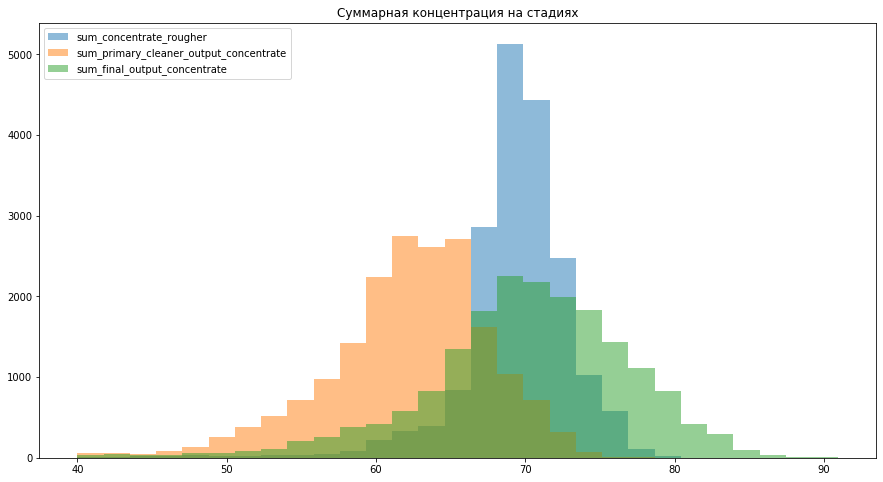

In [22]:
plt.figure(figsize=(15, 8))
analytics_steps(x, 'Суммарная концентрация на стадиях')

Все хорошо. Теперь все тоже самое делаем для train

In [23]:
# Сумма концентраций металлов после флотации
train['sum_concentrate_rougher']=train['rougher.output.concentrate_ag']+train['rougher.output.concentrate_pb']+train['rougher.output.concentrate_sol']+train['rougher.output.concentrate_au']

# Сумма концентраций металлов после первичной очистки
train['sum_primary_cleaner_output_concentrate']=train['primary_cleaner.output.concentrate_ag']+train['primary_cleaner.output.concentrate_pb']+train['primary_cleaner.output.concentrate_sol']+train['primary_cleaner.output.concentrate_au']

# Сумма концентраций металлов после финальной очистки
train['sum_final_output_concentrate']=train['final.output.concentrate_ag']+train['final.output.concentrate_pb']+train['final.output.concentrate_sol']+train['final.output.concentrate_au']

train_concentrate_sum=train[['sum_concentrate_rougher','sum_primary_cleaner_output_concentrate','sum_final_output_concentrate']]

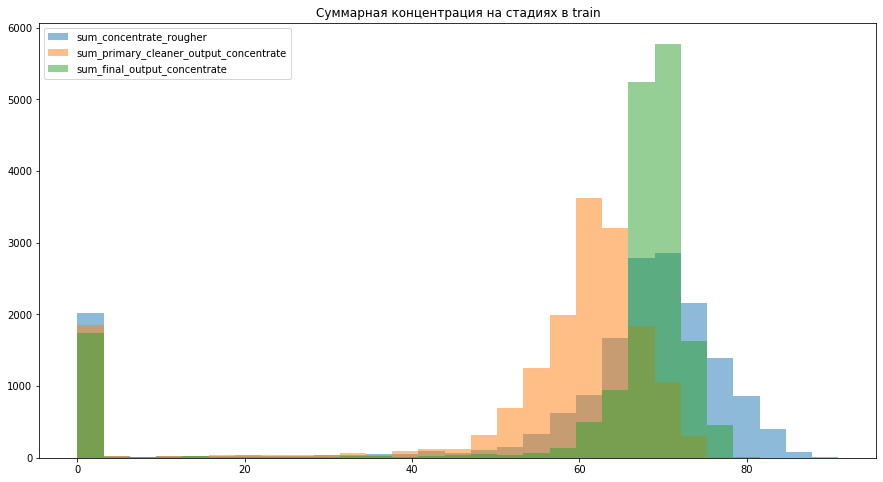

In [24]:
plt.figure(figsize=(15, 8))
analytics_steps(train_concentrate_sum, 'Суммарная концентрация на стадиях в train')

In [25]:
train=train.query('sum_final_output_concentrate > 40')
train=train.query('sum_primary_cleaner_output_concentrate > 40')
train=train.query('sum_concentrate_rougher > 40')

train.query('sum_concentrate_rougher <= 40')

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,sum_concentrate_rougher,sum_primary_cleaner_output_concentrate,sum_final_output_concentrate


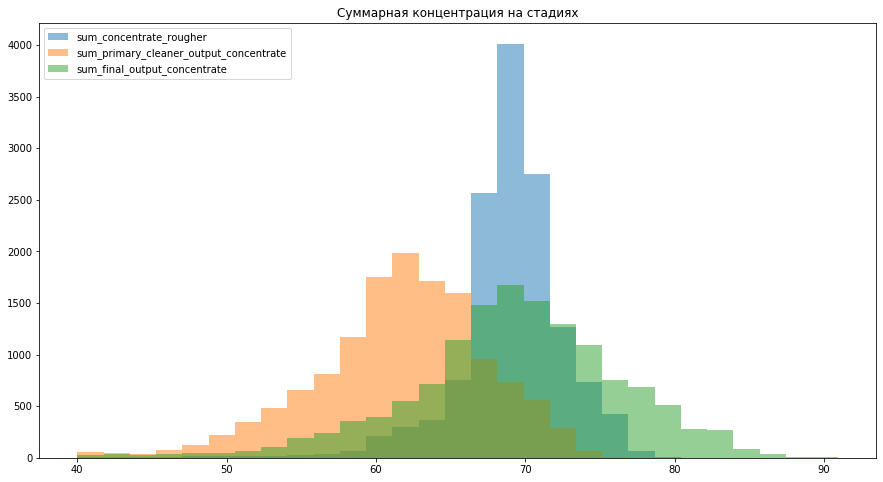

In [26]:
y = train[['sum_final_output_concentrate', 'sum_primary_cleaner_output_concentrate', 'sum_concentrate_rougher']]
plt.figure(figsize=(15, 8))
analytics_steps(y, 'Суммарная концентрация на стадиях')

Все хорошо х2

## Модель

In [27]:
def sMAPE(y_true,y_pred):
    
    error = np.mean(abs(y_true - y_pred)/((abs(y_true)+abs(y_pred))/2))*100
    
    return error

In [28]:
def final_sMAPE(sMAPE_rougher,sMAPE_final):
    
    return (0.25*sMAPE_rougher + 0.75*sMAPE_final)

In [29]:
#Надо взять из train не целевые признаки, а целевые присвоить переменной target
train = train.reset_index()
col = test.columns

feature = train[col]

feature = feature.drop(['date'], axis=1) #Убираю колонку с датой, потому что она не поможет в обучении
target = train[['rougher.output.recovery','final.output.recovery']]

In [30]:
smape_scores = []
mae_score = []

sample_size = int(len(target)/5)

for i in range(0, len(target), sample_size):
    
    valid_indexes = feature.iloc[i: i + sample_size].index
    train_indexes = feature.query('index not in @valid_indexes').index
    
    features_train = feature.iloc[train_indexes]
    features_valid = feature.iloc[valid_indexes]
    target_train = target.iloc[train_indexes]
    target_valid = target.iloc[valid_indexes]
       
    model = LinearRegression()
    model = model.fit(features_train, target_train)
    predict_linear = model.predict(features_valid)
    
    mae = mean_absolute_error(predict_linear,target_valid)
    mae_score.append(mae)
    
    smape = sMAPE(target_valid, predict_linear)
    smape_scores.append(smape)

smape_lin = np.mean(smape_scores)
    
print()
print('Оценка линейной регрессии метрикой sMAPE:', smape_lin)
print('Оценка линейной регрессии метрикой MAE:', np.mean(mae_score))


Оценка линейной регрессии метрикой sMAPE: 8.519274553153874
Оценка линейной регрессии метрикой MAE: 6.075981919488964


In [31]:
smape_scores = []
mae_score = []
smape_tree = 100000
best_depth = 0
mae = 0

sample_size = int(len(target)/5)

for i in range(0, len(target), sample_size):
    
    valid_indexes = feature.iloc[i: i + sample_size].index
    train_indexes = feature.query('index not in @valid_indexes').index
    
    features_train = feature.iloc[train_indexes]
    features_valid = feature.iloc[valid_indexes]
    target_train = target.iloc[train_indexes]
    target_valid = target.iloc[valid_indexes]
       
    for depth in range(1, 6):
        
        model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
        model.fit(features_train, target_train)
        predict_tree = model.predict(features_valid)
               
        mae = mean_absolute_error(predict_tree,target_valid)
        mae_score.append(mae)
    
        smape = sMAPE(target_valid, predict_tree)
        smape_scores.append(smape)
        
        if smape_tree > np.mean(smape_scores):
            smape_tree = np.mean(smape_scores)
            best_depth = depth
            mae = np.mean(mae_score)
        
print()
print('depth:', best_depth)
print('Оценка линейной регрессии метрикой sMAPE:', smape_tree)
print('Оценка линейной регрессии метрикой MAE:', mae)


depth: 5
Оценка линейной регрессии метрикой sMAPE: 7.926571934497113
Оценка линейной регрессии метрикой MAE: 5.6413408576859165


In [32]:
start = time.time()

smape_scores = []
mae_score = []

smape_forest = 100000
best_model_forest = None
best_depth = 0
best_est = 0
mae = 0

sample_size = int(len(target)/5)

for i in range(0, len(target), sample_size):
    
    valid_indexes = feature.iloc[i: i + sample_size].index
    train_indexes = feature.query('index not in @valid_indexes').index
    
    features_train = feature.iloc[train_indexes]
    features_valid = feature.iloc[valid_indexes]
    target_train = target.iloc[train_indexes]
    target_valid = target.iloc[valid_indexes]
       
    for est in range(30, 51, 10):
        for depth in range (3, 6):
                
            model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
            model.fit(features_train, target_train)
            predict_forest = model.predict(features_valid)
               
            mae = mean_absolute_error(predict_forest,target_valid)
            mae_score.append(mae)
    
            smape = sMAPE(target_valid, predict_forest)
            smape_scores.append(smape)
        
            if smape_forest > np.mean(smape_scores):
                smape_forest = np.mean(smape_scores)
                best_depth = depth
                best_est = est
                best_model_forest = model
                mae = np.mean(mae_score)
        
end = time.time()

print()
print('depth:', best_depth, 'est:', best_est)
print('Оценка линейной регрессии метрикой sMAPE:', smape_forest)
print('Оценка линейной регрессии метрикой MAE:', mae)
print('Скорость:', end - start, 's')


depth: 5 est: 50
Оценка линейной регрессии метрикой sMAPE: 7.518031934727044
Оценка линейной регрессии метрикой MAE: 5.313263476107668
Скорость: 304.8235023021698 s


In [33]:
#model = ['smape_forest', 'smape_tree', 'smape_lin']

dictionary = {
    
    'Regressor' : ['Случайный лес', 'Дерево решений', 'Линейная'],
    'sMAPE' : [smape_forest, smape_tree, smape_lin],
    
}

final = pd.DataFrame(dictionary)
final.sort_values(by='sMAPE', ascending = True)

,Regressor,sMAPE
0,Случайный лес,7.518032
1,Дерево решений,7.926572
2,Линейная,8.519275


Модель случайного леса показала себя лучше всего. Применим к тестовой выборке.

In [62]:
target = full[['date','rougher.output.recovery','final.output.recovery']]

#В target попало 18767 строк

test_2 = test.merge(target, on=['date'], how='left')

#В test было 5856 строк, в test_2 сохранилось такое же количество учитывая NaN

test_3 = test_2.dropna().reset_index(drop=True)

#Удалил NaN осталось 5074 строк

target_test = test_3[['rougher.output.recovery','final.output.recovery']]

#В target_test также осталось 5074 строки

feature_test = test_3.drop(['date','rougher.output.recovery','final.output.recovery'], axis=1)

#В feature_test 5074 строк

In [36]:
test_2.index

RangeIndex(start=0, stop=5074, step=1)

In [37]:
target_test.index

RangeIndex(start=0, stop=5074, step=1)

In [38]:
feature_test.index

RangeIndex(start=0, stop=5074, step=1)

In [63]:
len(target)

18767

In [64]:
len(test)

5856

In [65]:
len(test_2)

5856

In [66]:
len(test_3)

5074

In [67]:
len(target_test)

5074

In [68]:
len(feature_test)

5074

In [69]:
predict_forest_test = best_model_forest.predict(feature_test)
smape_forest = sMAPE(target_test, predict_forest_test)
smape_forest

rougher.output.recovery    5.923758
final.output.recovery      7.908174
dtype: float64

In [70]:
final_sMAPE(5.923758, 7.908174)

7.41207

Итоговое sMAPE: 7,41207
    
    - Лучшей моделью выбран алгоритм RandomForestRegressor
    - Подобранные параметры depth: 5, est: 50